# Исследование рынка заведений общественного питания Москвы

Цель - исследование рынка заведений общественного питания, их видов, расположения, количества посадочных мест и т.п. с тем, чтобы оценить перспективность проекта нового кафе.

[1. Предобработка данных](#1)

[2. Дополнение данных](#2)

[3. Анализ данных](#3)
- [соотношение видов объектов общественного питания по количеству](#3.1)
- [соотношение сетевых и несетевых заведений по количеству](#3.2)
- [для какого вида объекта общественного питания характерно сетевое распространение](#3.3)
- [Что характерно для сетевых заведений](#3.4)
- [среднее количество посадочных мест по видам заведений](#3.5)
- [график топ-10 улиц по количеству объектов общественного питания](#3.6)
- [улицы с одним объектом общественного питания](#3.7)
- [распределение количества посадочных мест для улиц с большим количеством объектов](#3.8)

[4. Выводы и презентация](#4)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import requests
import re

from keplergl import KeplerGl

# yandex geocoder apikey
# apikey

pd.options.display.max_colwidth = 200


##  1. Предобработка данных <a name="1"></a>

In [2]:
data = pd.read_csv('./rest_data.csv', index_col = 0)
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 840.3+ KB


In [4]:
data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [5]:
data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [6]:
# проверяем, все ли Id уникальные
data['id'].nunique()

15366

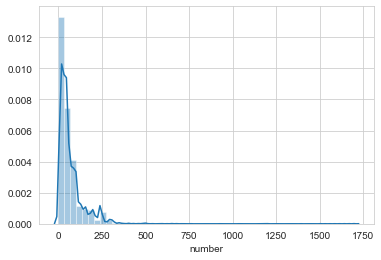

In [7]:
sns.distplot(data['number'])

In [8]:
data[data['number']>1500]

,id,object_name,chain,object_type,address,number
12723,199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, дом 36, строение 11",1700


Что мы проверили:
- все ячейки заполнены
- chain указан как да/нет, никаких других вариантов
- object_type прописан без ошибок и дубликатов
- все id уникальны
- количество посадочных мест в одном месте большое, и это правда, оно такое.

Нужно проверить адреса и выделить отдельный столбец с улицей.

In [9]:
# не везде прописан город Москва
data['city'] = data['address'].str.contains('город Москва,', regex=False)
data.loc[data['city'] == False, 'address'] = 'город Москва,' + data['address']

In [10]:
# отдельный столбец с улицей
pattern = '\,(([а-яА-Я0-9\-ё\s]+)?(площадь|улица|переулок|шоссе|проезд|проспект|набережная|бульвар|аллея|линия)([а-яА-Яё0-9\-ё\s]+)?)\,'

data['street'] = data['address'].str.extract(pat = pattern)[0]
data.drop('city', axis = 1, inplace = True)
data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


##  2. Дополнение данных <a name="2"></a>

Используем [геокодер Яндекса](https://tech.yandex.ru/maps/geocoder/doc/desc/concepts/input_params-docpage/), чтобы получить координаты для всех точек. Затем можно будет получить район (это нужно для анализа, в каких районах Москвы находятся улицы с самым большим и маленьким количеством объектов питания), а координаты использовать для визуализации геоданных. 

Район лучше получать именно отсюда: простого словарика "как улицы соотносятся с районами" было бы недостаточно, одна улица может находиться в нескольких районах. Выберем тот, в котором, собственно, находится объект общественного питания. 

In [11]:
URL = 'https://geocode-maps.yandex.ru/1.x'

# получение координат
def geocode(address):
    params = { 
        "geocode" : address, 
        "apikey": apikey,
        "format": "json"
        }
    response = requests.get(URL, params=params)
    response_json = response.json()
    try:
        return response_json['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
    except Exception as e:
        print("for address", address)
        print("result is", response_json)
        print("which raises", e)
        return ""

In [12]:
# получение района из координат
def reverse_geocode(coordinates):
    params = { 
        "geocode" : coordinates, 
        "apikey": apikey,
        "format": "json", 
        "kind" : "district"
        }
    response = requests.get(URL, params=params)
    response_json = response.json()
    try:
        return (response_json['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']
                ['GeocoderMetaData']['AddressDetails']['Country']['AddressLine'])
    except Exception as e:
        print("for coordinates", coordinates)
        print("result is", response_json)
        print("which raises", e)
        return ""

In [13]:
#data['coordinates'] = data['address'].apply(geocode)
#data['district'] = data['coordinates'].apply(reverse_geocode)
#data.to_csv('./rest_coordinates.csv')
data_coord = pd.read_csv('./rest_coordinates.csv', index_col = 0)
data_coord.head()

,id,object_name,chain,object_type,address,number,street,coordinates,district
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,37.714474 55.879005,"Россия, Москва, Северо-Восточный административный округ, Ярославский район"
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,37.673295 55.738307,"Россия, Москва, Центральный административный округ, Таганский район"
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,37.669576 55.735571,"Россия, Москва, Центральный административный округ, Таганский район"
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,37.573007 55.892713,"Россия, Москва, Северо-Восточный административный округ, район Лианозово"
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,37.572279 55.904074,"Россия, Москва, Северо-Восточный административный округ, район Лианозово"


Адреса, которые не геокодировались, расположены на МКАД в основном. Их мало, можно не обращать внимания.

In [14]:
len(data_coord[data_coord['coordinates'].isnull()])

32

In [15]:
# две отдельные колонки lon lat
coordinates = data_coord['coordinates'].str.split(" ", expand = True)
coordinates.columns = ['lon', 'lat']

In [16]:
data_coord = data_coord.join(coordinates)

In [17]:
# приведение их к нужному типу
data_coord['lon'] = data_coord['lon'].astype('float64')
data_coord['lat'] = data_coord['lat'].astype('float64')

Округ и район не получаются для Новой Москвы и Зеленограда, можно так и приписать. 
Еще есть одна смешная ошибка - Деловой квартал "Симоновский" не имеет округа и района. Есть еще мелкие ошибки, где-то вместо округа и района на этом месте прописан жилой комплекс, но это уже не так существенно.

In [18]:
# выделение информации об округе из полученных данных о районе
pattern = '\,(([а-яА-Я\-ё\s]+)?(административный округ)()?)\,'

data_coord['okrug'] = data_coord['district'].str.extract(pat = pattern)[0]

In [19]:
# выделение информации о районе из полученных данных
pattern = '\,(([а-яА-Я0-9\-ё\s]+)?(район|район )([а-яА-Я0-9\-ё\s]+)?)'

data_coord['rayon'] = data_coord['district'].str.extract(pat = pattern)[0]

In [20]:
# ТиНАО
data_coord.loc[(data_coord['okrug'].isnull())&(data_coord['coordinates'].notnull()), 'okrug'] = 'ТиНАО'

# Зеленоград
data_coord.loc[data_coord['district'].str.startswith('Россия, Москва, Зеленоград', na=False), 'okrug'] = 'Зеленоградский административный округ'

# Деловой квартал "Симоновский"
data_coord.loc[data_coord['district'] == 'Россия, Москва, Деловой квартал Симоновский', 'okrug'] = ' Южный административный округ'
data_coord.loc[data_coord['district'] == 'Россия, Москва, Деловой квартал Симоновский', 'rayon'] = 'Даниловский район'

In [21]:
data_coord.head()

,id,object_name,chain,object_type,address,number,street,coordinates,district,lon,lat,okrug,rayon
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,37.714474 55.879005,"Россия, Москва, Северо-Восточный административный округ, Ярославский район",37.714474,55.879005,Северо-Восточный административный округ,Ярославский район
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,37.673295 55.738307,"Россия, Москва, Центральный административный округ, Таганский район",37.673295,55.738307,Центральный административный округ,Таганский район
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,37.669576 55.735571,"Россия, Москва, Центральный административный округ, Таганский район",37.669576,55.735571,Центральный административный округ,Таганский район
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,37.573007 55.892713,"Россия, Москва, Северо-Восточный административный округ, район Лианозово",37.573007,55.892713,Северо-Восточный административный округ,район Лианозово
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,37.572279 55.904074,"Россия, Москва, Северо-Восточный административный округ, район Лианозово",37.572279,55.904074,Северо-Восточный административный округ,район Лианозово


In [22]:
config_1 = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 's2s35nh',
     'type': 'grid',
     'config': {'dataId': 'food_points',
      'label': 'Point',
      'color': [18, 147, 154],
      'columns': {'lat': 'lat', 'lng': 'lon'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'worldUnitSize': 0.7,
       'colorRange': {'name': 'ColorBrewer GnBu-9',
        'type': 'sequential',
        'category': 'ColorBrewer',
        'colors': ['#084081',
         '#0868ac',
         '#2b8cbe',
         '#4eb3d3',
         '#7bccc4',
         '#a8ddb5',
         '#ccebc5',
         '#e0f3db',
         '#f7fcf0'],
        'reversed': True},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'colorAggregation': 'sum',
       'sizeAggregation': 'sum',
       'enable3d': True},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'number', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'number', 'type': 'integer'},
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'food_points': ['id',
       'object_name',
       'chain']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 24,
   'dragRotate': True,
   'latitude': 55.71125246810893,
   'longitude': 37.567937909753205,
   'pitch': 50,
   'zoom': 10.614783279523946,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [23]:
map_1 = KeplerGl(height=700)

map_1.add_data(data=data_coord, name='food_points')
map_1.config = config_1
map_1.save_to_html(file_name='map_1_density.html')


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to map_1_density.html!


Визуализация показывает суммарное количество посадочных мест на ячейку сетки; наибольшая концентрация в центре города, внутри Бульварного кольца, и в Москве-сити. Еще высокие значения: вдоль Тверской, на Новокузнецкой, на Таганке, на Киевской и вдоль Арбата. Без сюрпризов, но все равно интересно. Посмотрим также, как распределяется количество заведений по округам.

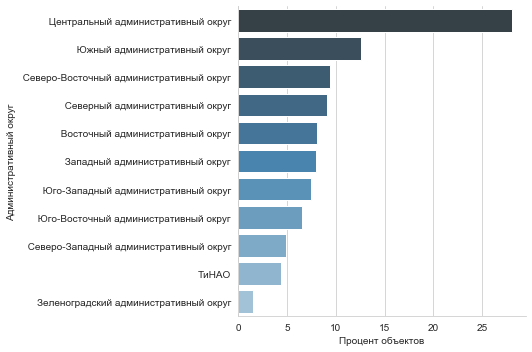

In [24]:
okrug = data_coord['okrug'].value_counts(normalize=True).mul(100)\
.rename('okrug').reset_index()

g = sns.catplot(y="index", x = 'okrug', kind = 'bar', data=okrug, palette="Blues_d", height=5, aspect=1.5)
g.set_ylabels("Административный округ")
g.set_xlabels("Процент объектов")

##  3. Анализ данных <a name="3"></a>

### Соотношение видов объектов общественного питания по количеству <a name="3.1"></a>

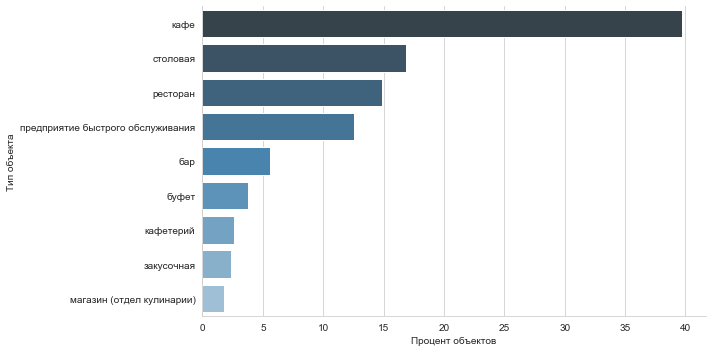

In [25]:
# процент каждого вида от общего числа заведений
percent = data_coord['object_type'].value_counts(normalize=True).mul(100)\
.rename('percent').reset_index()

g = sns.catplot(y="index", x = 'percent', kind = 'bar', data=percent, palette="Blues_d", height=5, aspect=2)
g.set_ylabels("Тип объекта")
g.set_xlabels("Процент объектов")

Ну, тут вопрос, откуда данные. Почти 40% - кафе, еще примерно по 15% - столовая и ресторан, еще 12% - фастфуд. Кафе и ресторан - самые расплывчатые категории, нет четких критериев, которым они должны соответствовать, скорее всего, это то, в какую категорию заведение относит себя само; где, например, граница между рестораном и баром - это вопрос.

### Соотношение сетевых и несетевых заведений по количеству <a name="3.2"></a>

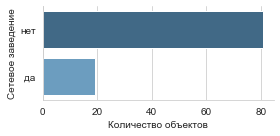

In [26]:
# процент каждого вида от общего числа заведений
percent_total = data_coord['chain'].value_counts(normalize=True).mul(100)\
.rename('percent').reset_index()

g = sns.catplot(y="index", x = 'percent', kind = 'bar', data=percent_total, palette="Blues_d", height=2, aspect=2)
g.set_ylabels("Сетевое заведение")
g.set_xlabels("Количество объектов")

80/20 - это неожиданный процент. Почему-то интуитивно казалось, что сетевых заведений должно быть больше. Но, видимо, столовых и маленьких одиночных кафе куда больше, чем кажется.

### Для какого вида объекта общественного питания характерно сетевое распространение <a name="3.3"></a>

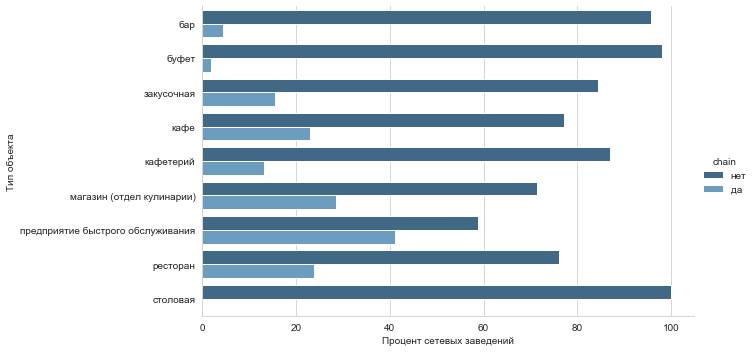

In [27]:
# процент сетевых заведений для каждого отдельного типа
percent_chain = data_coord.groupby('object_type')['chain'].value_counts(normalize=True).mul(100)\
.rename('percent').reset_index()
#график - процент сетевых заведений для каждого вида
g=sns.catplot(y="object_type", x='percent', hue='chain',kind='bar',data=percent_chain, palette="Blues_d", height=5, aspect=2)
g.set_ylabels("Тип объекта")
g.set_xlabels("Процент сетевых заведений")

Тут тоже без сюрпризов. Больше всего сетевое распространение характерно для фастфуда, магазинов с кулинарией и кафе. Почти нет сетевых столовых, баров и буфетов.

### Что характерно для сетевых заведений <a name="3.4"></a>

In [28]:
data_coord.groupby('chain')['number'].describe()

,count,mean,std,min,25%,50%,75%,max
chain,,,,,,,,
да,2968.0,52.919811,57.140644,0.0,15.0,40.0,72.0,580.0
нет,12398.0,61.133731,78.284046,0.0,12.0,40.0,80.0,1700.0


In [29]:
# почистим самые заметные проблемы с названиями
data_coord['object_name'].replace('ШОКОЛАДНИЦА', 'Шоколадница', inplace = True)
data_coord['object_name'].replace('МАКДОНАЛДС', 'Макдоналдс', inplace = True)
data_coord['object_name'].replace('Старбакс', 'Starbucks', inplace = True)
data_coord['object_name'].replace('Кафе «Шоколадница»', 'Шоколадница', inplace = True)
data_coord['object_name'].replace('Кафе «KFC»', 'KFC', inplace = True)
data_coord['object_name'].replace('Сабвей', 'Subway', inplace = True)
data_coord['object_name'].replace('Ресторан «Макдоналдс»', 'Макдоналдс', inplace = True)
data_coord['object_name'].replace('Братья Караваевы', 'Кулинарная лавка братьев Караваевых', inplace = True)
data_coord['object_name'].replace('БУРГЕР КИНГ', 'Бургер Кинг', inplace = True)
data_coord['object_name'].replace('ТЕРЕМОК', 'Теремок', inplace = True)
data_coord['object_name'].replace('МУ-МУ', 'Му-Му', inplace = True)
data_coord['object_name'].replace('Додо пицца', 'Додо Пицца', inplace = True)
data_coord['object_name'].replace('Прайм', 'Прайм стар', inplace = True)
data_coord['object_name'].replace('Хлеб Насущный', 'Хлеб насущный', inplace = True)
data_coord['object_name'].replace('Суши Вок', 'Суши Wok', inplace = True)

Text(0.5, 0, 'Среднее количество посадочных мест')

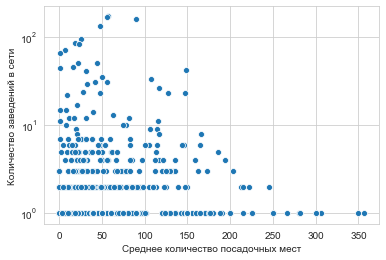

In [30]:
# сводная таблица с количеством заведений в сети и средним количеством посадочных мест в ней
chain_yes = data_coord[data_coord['chain']=='да']\
.groupby('object_name')[['number', 'id']].agg({'id':'nunique', 'number':'mean'})\
.sort_values(by = 'id', ascending = False)

ax = sns.scatterplot(data = chain_yes, x = 'number', y = 'id')
ax.set_yscale('log')
ax.set_ylabel('Количество заведений в сети')
ax.set_xlabel('Среднее количество посадочных мест')

Если выбирать из двух вариантов - много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест - то скорее верно первое, заведений довольно много, а мест в них мало. Среднее количество посадочных мест в сетевом заведении также меньше, чем в несетевом.

### Среднее количество посадочных мест по видам заведений <a name="3.5"></a>

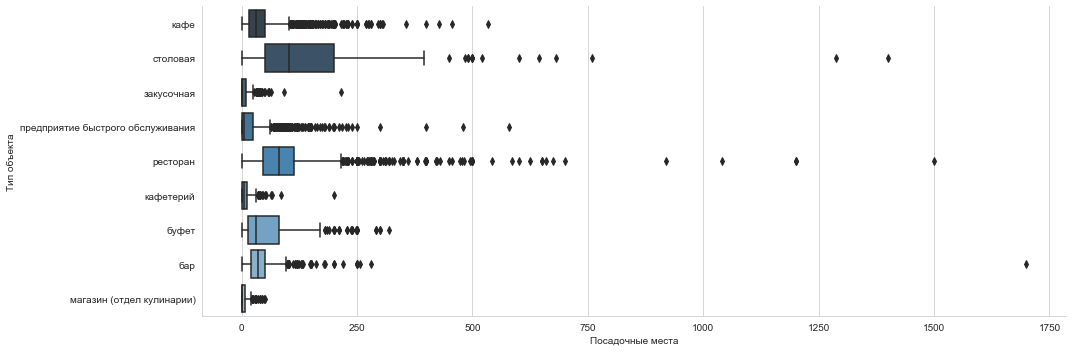

In [31]:
g = sns.catplot(y="object_type", x = 'number', kind="box", data=data_coord, palette="Blues_d", height=5, aspect=3)
g.set_ylabels("Тип объекта")
g.set_xlabels("Посадочные места")
#ax.set_xlim([0, 200])

In [32]:
data_coord.groupby('object_type')['number'].describe()

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
бар,856.0,43.494159,67.082876,0.0,20.0,35.0,50.0,1700.0
буфет,585.0,51.129915,56.331974,0.0,14.0,32.0,80.0,320.0
закусочная,360.0,7.608333,16.650912,0.0,0.0,0.0,10.0,216.0
кафе,6099.0,39.716019,37.720947,0.0,15.0,30.0,50.0,533.0
кафетерий,398.0,9.123116,14.639150,0.0,0.0,6.0,12.0,200.0
магазин (отдел кулинарии),273.0,5.589744,9.872729,0.0,0.0,0.0,8.0,50.0
предприятие быстрого обслуживания,1923.0,20.552262,38.366974,0.0,0.0,5.0,25.0,580.0
ресторан,2285.0,96.834136,94.756542,0.0,46.0,80.0,114.0,1500.0
столовая,2587.0,130.246618,95.179313,0.0,50.0,103.0,200.0,1400.0


Самое большое среднее количество посадочных мест - у столовых, второе - у ресторанов, потом идут буфеты, бары и кафе. Интересно, что в большинстве магазинов и закусочных это значение вообще равно нулю.

### График топ-10 улиц по количеству объектов общественного питания<a name="3.6"></a>

In [33]:
# сводная таблица - количество заведений на улице и районы для этих улиц
street_pivot = data_coord.dropna().groupby('street')[['id', 'rayon']]\
.agg({'id': 'nunique', 'rayon': 'unique'}).reset_index()
# топ-10 улиц по количеству заведений - со всеми районами, через которые они проходят
top_ten_streets = street_pivot.sort_values(by = 'id', ascending = False).head(10)
top_ten_streets

,street,id,rayon
1368,проспект Мира,204,"[ Мещанский район, Останкинский район, Алексеевский район, район Ростокино, район Свиблово, Ярославский район]"
980,Профсоюзная улица,174,"[ Академический район, район Черёмушки, Обручевский район, район Коньково, район Тёплый Стан, район Ясенево]"
663,Ленинградский проспект,171,"[ район Беговой, район Аэропорт, район Сокол, Хорошёвский район]"
965,Пресненская набережная,167,[ Пресненский район]
385,Варшавское шоссе,161,"[ Донской район, Нагорный район, район Чертаново Южное, район Чертаново Северное, район Чертаново Центральное, район Нагатино-Садовники, район Южное Бутово]"
666,Ленинский проспект,147,"[ район Якиманка, Донской район, Гагаринский район, Ломоносовский район, Обручевский район, район Тропарёво-Никулино, район Тёплый Стан, район Проспект Вернадского]"
1364,проспект Вернадского,131,"[ Гагаринский район, Ломоносовский район, район Проспект Вернадского, район Тропарёво-Никулино, микрорайон Ленинские Горы, район Раменки]"
654,Кутузовский проспект,114,"[ район Фили-Давыдково, район Дорогомилово]"
579,Каширское шоссе,112,"[ район Нагатино-Садовники, район Москворечье-Сабурово, район Орехово-Борисово Южное, район Орехово-Борисово Северное]"
585,Кировоградская улица,110,"[ район Чертаново Центральное, район Чертаново Южное, район Чертаново Северное]"


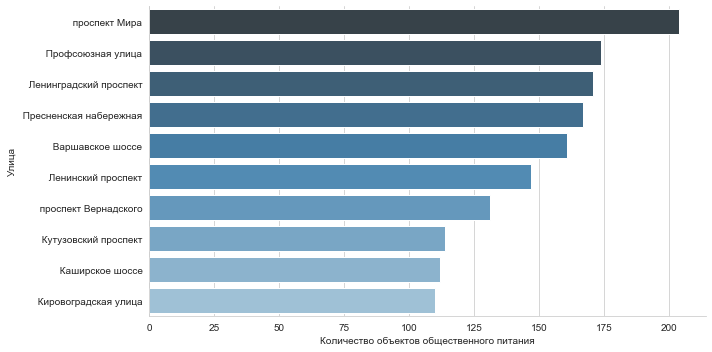

In [34]:
#график топ-10 улиц по количеству заведений 
g=sns.catplot(y="street", x='id', kind='bar',data=top_ten_streets, palette="Blues_d", height=5, aspect=2)
g.set_ylabels("Улица")
g.set_xlabels("Количество объектов общественного питания")

На самом деле, это не "самые оживленные улицы", это просто самые длинные улицы - это видно на карте в части про распределение посадочных мест на этих улицах. Самые оживленные места все равно в центре.

### Улицы с одним объектом общественного питания <a name="3.7"></a>

In [35]:
one_object_streets = street_pivot[street_pivot['id']==1]
one_object_streets.head()

,street,id,rayon
2,1-й Балтийский переулок,1,[ район Аэропорт]
3,1-й Басманный переулок,1,[ Красносельский район]
4,1-й Ботанический проезд,1,[ район Свиблово]
7,1-й Вешняковский проезд,1,[ Рязанский район]
9,1-й Голутвинский переулок,1,[ район Якиманка]


In [36]:
one_place_per_street = data_coord[data_coord['street'].isin(one_object_streets['street'])]
map_2 = KeplerGl(height=500)
# распределение улиц с одним заведением на карте
map_2.add_data(data=one_place_per_street, name='one_place_per_street')
map_2.save_to_html(file_name='map_2_one_object.html')


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to map_2_one_object.html!


Тут тоже дело не в том, что на этих улицах мало мест, а в том, что улицы коротенькие - больше всего таких улиц в центре, как видно на карте.

### Распределение количества посадочных мест для улиц с большим количеством объектов <a name="3.8"></a>

In [37]:
# выборка мест на топ-10 улиц
density_places = data_coord[data_coord['street'].isin(top_ten_streets['street'])]

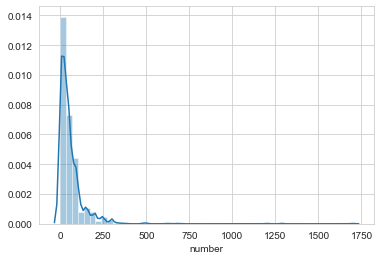

In [38]:
sns.distplot(density_places['number'])

In [39]:
# распределение для всего датасета
data_coord['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [40]:
# распределение для топ-10 улиц
density_places['number'].describe()

count    1503.000000
mean       57.966733
std        89.982933
min         0.000000
25%        12.000000
50%        40.000000
75%        75.000000
max      1700.000000
Name: number, dtype: float64

In [41]:
config_3 = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'qtangt',
     'type': 'point',
     'config': {'dataId': 'density_places',
      'label': 'Point',
      'color': [30, 150, 190],
      'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer PuBu-6',
        'type': 'sequential',
        'category': 'ColorBrewer',
        'colors': ['#f1eef6',
         '#d0d1e6',
         '#a6bddb',
         '#74a9cf',
         '#2b8cbe',
         '#045a8d']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'number', 'type': 'integer'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': {'name': 'number', 'type': 'integer'},
      'sizeScale': 'sqrt'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'density_places': ['id',
       'object_name',
       'chain',
       'object_type',
       'address']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 55.713231814717574,
   'longitude': 37.64091885537051,
   'pitch': 0,
   'zoom': 9.451941083083048,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [42]:
map_3 = KeplerGl(height=500)
# распределение количества посадочных мест на улицах с самым большим количеством заведений
map_3.add_data(data=density_places, name='density_places')
map_3.config = config_3
map_3.save_to_html(file_name='map_3_long_streets.html')


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to map_3_long_streets.html!


На гистограмме и при применении метода describe видно, что это тот же самый разброс, что и в общем датасете, с примерно одинаковым средним и совпадающей медианой в 40. На карте видно, что количество посадочных мест самое разное и не зависит от положения и близости к центру.

## Выводы и презентация <a name="4"></a>

Оптимальным при открытии кафе представляется следующее:
- открывать именно кафе или ресторан, а не бар и не фастфуд
- не делать большого заведения (60 посадочных мест - среднее значение по Москве),
- постараться открыть кафе в центре внутри Садового кольца или около Нового Арбата/Ленинградского проспекта
- не развивать сеть, пока одно кафе не будет успешным, и даже, возможно, после этого не развивать сеть, пусть оно остается уникальным продуктом.

А вообще кафе с роботами хорошо бы делать около чего-то подходящего: например, музея [Экспериментаниум](https://experimentanium.ru/). Тогда проблемы с тем, что всем скоро надоест идея, не будет :)